In [1]:
import torch
import torch.nn as nn
from torch.autograd.variable import Variable
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataUtils.CustomDataset as CastomDataset
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
workers = 20
btch_sz = 32
lr = 0.02
beta1 = 0.5
ngpu = 1

In [3]:
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Training data preprocessing

240 (1365, 2048, 3) [0 0 1 0]
241 (1365, 2048, 3) [0 0 1 0]
242 (1365, 2048, 3) [0 0 0 1]
243 (1365, 2048, 3) [0 0 0 1]
244 (1365, 2048, 3) [0 0 1 0]
245 (2048, 1365, 3) [0 1 0 0]
246 (1365, 2048, 3) [1 0 0 0]
247 (1365, 2048, 3) [1 0 0 0]
248 (1365, 2048, 3) [1 0 0 0]
249 (1365, 2048, 3) [1 0 0 0]
250 (1365, 2048, 3) [0 0 0 1]
251 (1365, 2048, 3) [0 0 0 1]


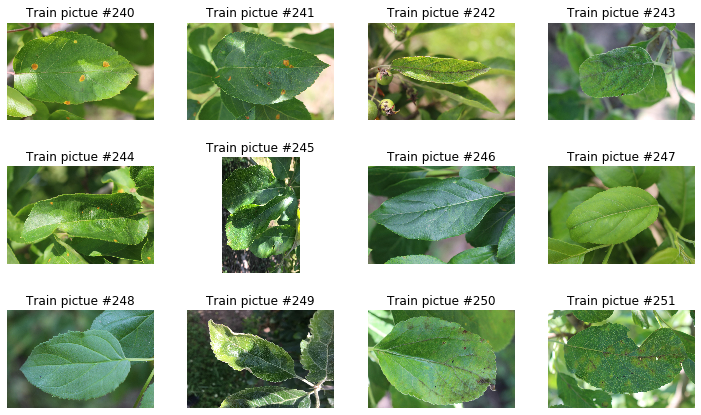

In [4]:
plant_dataset = CastomDataset.PlantPathologyDataset('train.csv', 'images/train')

plt.figure(figsize=(10,10))
for i in range(240,252):
    sample = plant_dataset[i]
    print(i, sample['image'].shape, sample['labels'])
    
    ax = plt.subplot(5, 4, i-239)
    plt.tight_layout()
    ax.set_title('Train pictue #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'][:, ::-1])
   

In [ ]:
from dataUtils.DataAugmentation import DataAugmentation

data_augmentation = DataAugmentation('images/train/', im_shape=(700,700))
data_augmentation.generate(path_to_save='images/train_new/')

In [31]:
df = pd.read_csv('train.csv')
validation = df[1790:]
train = df[:1789]
validation.to_csv('validation.csv', index=False)

In [32]:
import re
import os
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

images_names = sorted_alphanumeric(os.listdir('images/train_new'))
train_new = pd.DataFrame(np.repeat(train.values,8,axis=0))
train_new.columns = train.columns
train_new.image_id = images_names
train_new['image_id'] = train_new['image_id'].map(lambda x: x.rstrip('.jpg'))
train_new.to_csv('train_new.csv')

images_names = sorted_alphanumeric(os.listdir('images/valid_new'))
valid_new = pd.DataFrame(np.repeat(validation.values,8,axis=0))
valid_new.columns = validation.columns
valid_new.image_id = images_names
valid_new['image_id'] = valid_new['image_id'].map(lambda x: x.rstrip('.jpg'))
valid_new.to_csv('valid_new.csv')

In [7]:
train_new

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0_0,0,0,0,1
1,Train_0_1,0,0,0,1
2,Train_0_2,0,0,0,1
3,Train_0_3,0,0,0,1
4,Train_0_4,0,0,0,1
...,...,...,...,...,...
14307,Train_1788_3,0,0,1,0
14308,Train_1788_4,0,0,1,0
14309,Train_1788_5,0,0,1,0
14310,Train_1788_6,0,0,1,0


# Format dataloader

In [4]:
plant_dataset = CastomDataset.PlantPathologyDataset('train_new.csv',
                                                    'images/train_new',
                                                    transform=CastomDataset.ToTensor()
                                                   )

plant_dataset_valid = CastomDataset.PlantPathologyDataset('valid_new.csv',
                                                    'images/valid_new',
                                                    transform=CastomDataset.ToTensor()
                                                   )

plant_dataset_test = CastomDataset.PlantPathologyDataset('test.csv',
                                                    'images/test',
                                                    transform=CastomDataset.ToTensor(),
                                                    data_type='test'
                                                   )

dataloader = DataLoader(plant_dataset, batch_size=btch_sz,
                        shuffle=True, num_workers=workers,
                        )

dataloader_valid = DataLoader(plant_dataset_valid, batch_size=btch_sz,
                        shuffle=True, num_workers=workers,
                        )

dataloader_test = DataLoader(plant_dataset_test, batch_size=btch_sz,
                        shuffle=False, num_workers=workers,
                        )

In [17]:
batch = next(iter(dataloader_test))
batch['image'].shape

torch.Size([32, 3, 500, 500])

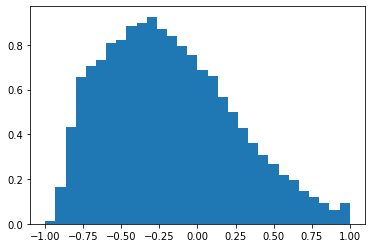

In [18]:
plt.hist(batch['image'].view(-1), bins=30, normed=True)
plt.show()

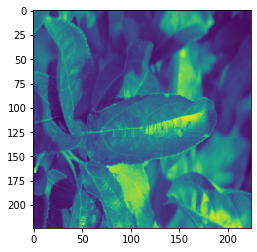

In [11]:
plt.imshow(batch['image'][0].sum(dim=0))
plt.show()
# print(batch['labels'][0])

In [12]:
image = plant_dataset[245]['image']
image.shape

torch.Size([3, 224, 224])

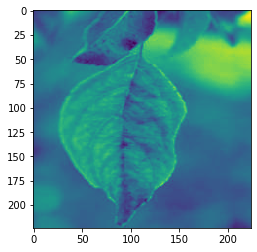

In [13]:
plt.imshow(image.sum(dim=0))
plt.show()

# Load VGG network

In [89]:
from torchvision import models
from torch import nn
from torch import optim

model = models.vgg16_bn(pretrained = True)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(25088, 4096),
                                 nn.LeakyReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(4096, 4)
                                )
print(sum(p.numel() for p in model.parameters()))
model.to(device)

In [30]:
model(batch['image'][:2].to(device)).shape

(torch.Size([2, 4]), torch.Size([2, 3, 224, 224]))

# Load PPC network

In [7]:
import models.PPCN as PPC

model = PPC.PlantPathologyClassifier(ngpu)
model.apply(PPC.weights_init)
print(sum(p.numel() for p in model.parameters()))
model.to(device)

57677632


PlantPathologyClassifier(
  (main_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(32,

In [ ]:
model(batch['image'][:3].to(device)).shape

# Optimirez and criterion loss

In [9]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
train_losses = np.array([])
valid_losses = np.array([])
train_accurasy = np.array([])
valid_accurasy = np.array([])

# Training loop

In [ ]:
num_epochs = 2
monit_res = 50
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        
        images, labels = batch['image'], batch['labels']
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        
        loss = criterion(output, torch.max(labels, 1)[1])
#         loss = criterion(output, labels[:, 0]) #########################
        loss.backward()
        optimizer.step()        
        
        running_loss += loss.item()
        
        
        if i%monit_res == monit_res-1:
            model.eval()
            predicted_idx = torch.max(output, 1)[1]
            true_idx = torch.max(labels, 1)[1]
            accurasy = sum(true_idx == predicted_idx).item()/len(true_idx)
#             accurasy = sum((output > 0.5).view(-1).cpu().detach()  == (labels[:, 0] > 0.5).cpu().detach()).item()/len(labels)
            
            train_accurasy = np.append(train_accurasy, accurasy)

            val_accurasy = 0
            running__valid_loss = 0.0
            for val_vatch in dataloader_valid:
                valid_images = val_vatch['image'].to(device)
                valid_labels = val_vatch['labels'].to(device)

                with torch.no_grad():
                    valid_output = model(valid_images)
                    valid_loss = criterion(valid_output, torch.max(valid_labels, 1)[1])
#                     valid_loss = criterion(valid_output, valid_labels[:, 0]) ###############
                running__valid_loss += valid_loss.item()/len(dataloader_valid)

                predicted_idx = torch.max(valid_output, 1)[1]
                
                true_idx = torch.max(valid_labels, 1)[1]
                val_accurasy += sum(true_idx == predicted_idx).item()/len(true_idx)/len(dataloader_valid)
#                 val_accurasy += sum((valid_output > 0.5).view(-1).cpu().detach()  == (valid_labels[:, 0] > 0.5).cpu().detach()).item()/len(valid_labels)/len(dataloader_valid)
                
            valid_accurasy = np.append(valid_accurasy, val_accurasy)

            if val_accurasy > 0.97:
                print(val_accurasy)
                print(ff)
            
            train_losses = np.append(train_losses, running_loss/monit_res)
            valid_losses = np.append(valid_losses, running__valid_loss)
            print('[{}/{}] [{}/{}], loss: {}, validation loss: {}, accyrasy: {}'.format(epoch,
                                                     num_epochs,
                                                     i*btch_sz,
                                                     btch_sz*len(dataloader),
                                                     round(running_loss/monit_res, 4),
                                                     round(running__valid_loss, 4),
                                                     round(val_accurasy, 4)
                                                    )
                 )
            running_loss = 0.0
            running__valid_loss = 0.0

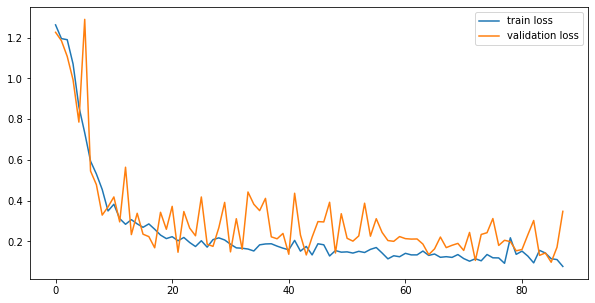

In [37]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()
plt.show()

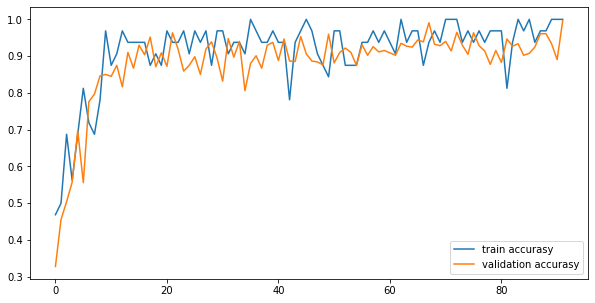

In [38]:
plt.figure(figsize=(10,5))
plt.plot(train_accurasy, label='train accurasy')
plt.plot(valid_accurasy, label='validation accurasy')
plt.legend()
plt.show()

# Prediction


In [39]:
model.eval()
accuracy = 0
prediction = torch.tensor([]).to(device)
for i, batch in enumerate(dataloader_test):
    
    images = batch['image']
    images = images.to(device)
    
    with torch.no_grad():
        output = model(images)
  
    
    predicted_idx = torch.max(output, 1)[1]
    prediction = torch.cat((prediction, output), 0)

    print(predicted_idx[:5])

tensor([2, 2, 3, 0, 2], device='cuda:0')
tensor([3, 3, 3, 3, 2], device='cuda:0')
tensor([3, 2, 0, 2, 1], device='cuda:0')
tensor([3, 0, 3, 3, 3], device='cuda:0')
tensor([2, 2, 3, 3, 0], device='cuda:0')
tensor([0, 3, 2, 2, 3], device='cuda:0')
tensor([1, 2, 2, 0, 3], device='cuda:0')
tensor([1, 0, 2, 3, 2], device='cuda:0')
tensor([3, 2, 1, 3, 3], device='cuda:0')
tensor([3, 3, 2, 2, 0], device='cuda:0')
tensor([2, 0, 0, 2, 2], device='cuda:0')
tensor([3, 2, 2, 3, 0], device='cuda:0')
tensor([2, 3, 1, 3, 0], device='cuda:0')
tensor([3, 2, 0, 0, 2], device='cuda:0')
tensor([2, 3, 2, 2, 2], device='cuda:0')
tensor([2, 3, 3, 2, 0], device='cuda:0')
tensor([0, 3, 0, 2, 2], device='cuda:0')
tensor([2, 2, 3, 2, 2], device='cuda:0')
tensor([3, 3, 0, 0, 2], device='cuda:0')
tensor([3, 0, 3, 0, 2], device='cuda:0')
tensor([3, 0, 3, 0, 3], device='cuda:0')
tensor([0, 2, 2, 0, 0], device='cuda:0')
tensor([2, 2, 0, 3, 3], device='cuda:0')
tensor([0, 3, 0, 2, 3], device='cuda:0')
tensor([0, 2, 0,

In [40]:
output.shape

torch.Size([29, 4])

In [41]:
softmax = nn.Softmax()
predict_soft = softmax(prediction)

In [42]:
predict_soft

tensor([[2.4169e-07, 1.3382e-03, 9.9866e-01, 1.1291e-11],
        [5.5281e-08, 1.4129e-03, 9.9859e-01, 8.5816e-12],
        [4.4646e-07, 1.0639e-05, 1.7625e-14, 9.9999e-01],
        ...,
        [2.9130e-12, 7.2409e-07, 1.0000e+00, 3.4889e-19],
        [9.9998e-01, 2.2027e-06, 9.3893e-09, 1.5174e-05],
        [1.3265e-07, 2.8784e-05, 2.0526e-14, 9.9997e-01]], device='cuda:0')

In [43]:
predict_soft = predict_soft.cpu().detach().numpy()

In [44]:
np.save('prediction', predict_soft)

In [21]:
predict_soft.shape

(1821, 4)

In [22]:
softmax(prediction)

tensor([[2.0651e-05, 1.2466e-01, 8.7500e-01, 3.1778e-04],
        [1.8223e-06, 3.8168e-02, 9.6181e-01, 2.4815e-05],
        [2.8192e-03, 1.5740e-02, 3.4573e-05, 9.8141e-01],
        ...,
        [9.5763e-07, 2.6397e-02, 9.7359e-01, 1.1523e-05],
        [9.9846e-01, 3.4702e-04, 2.3050e-05, 1.1745e-03],
        [2.5833e-03, 2.3623e-02, 7.0788e-05, 9.7372e-01]], device='cuda:0')

In [27]:
prediction

tensor([[ -6.9215,   2.9873,   9.3687, -13.7622],
        [ -7.5605,   3.4964,   7.3378, -10.8421],
        [ -4.7843,   2.1406, -22.8484,  13.0204],
        ...,
        [-10.3085,   3.5061,  11.9471, -17.1386],
        [  9.5634,  -3.2404,  -8.4592,  -1.6688],
        [ -3.6672,   1.6663, -15.7042,   8.8530]], device='cuda:0')

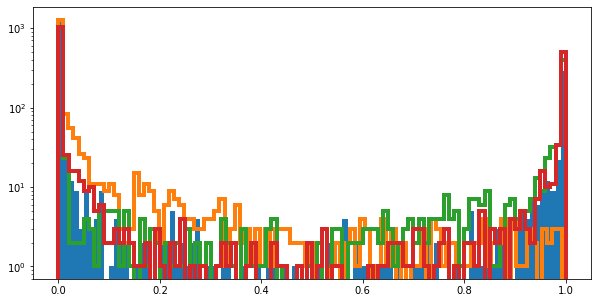

In [31]:
plt.figure(figsize=(10,5))
plt.hist(predict_soft[:, 0], bins=100)
plt.hist(predict_soft[:, 1], bins=100, histtype='step', lw=4)
plt.hist(predict_soft[:, 2], bins=100, histtype='step', lw=4)
plt.hist(predict_soft[:, 3], bins=100, histtype='step', lw=4)
plt.yscale('log')
plt.show()

In [46]:
predict_soft[:, 0][]

(1821,)